In [2]:
%reload_ext autoreload
%autoreload 2

from collections import Counter
import numpy as np
import pandas as pd
from app import Preprocessing

from matplotlib import pyplot as plt
import torch
import torch.nn as nn

dtype = torch.float
device = torch.device("cpu")

%load_ext Cython

In [3]:
pre = Preprocessing('IMDB')

In [4]:
pre.load_data(name='IMDB')

In [5]:
pre.data['train_raw'].head()

,text,POS__NEG
0,They're not jawing journalists Cary Grant and ...,1
1,"Watching John Cassavetes film, Opening Night, ...",1
2,"In short, the movie had a little bit of a weak...",0
3,Where to start... If this movie had been a dar...,0
4,This is one of those films that makes you want...,0


In [937]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()
pos_neg_ratios = Counter()

In [916]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
word1=''
for i in range(pre.data['Train'].shape[0]):
    if(pre.data['Train']['POS__NEG'][i] == 1):
        for word in pre.data['Train']['text'][i].split(" "):
            word2=word
            positive_counts[word1+' '+word2] += 1
            total_counts[word1+' '+word2] += 1
            word1=word2
    else:
        for word in pre.data['Train']['text'][i].split(" "):
            word2=word
            negative_counts[word1+' '+word2] += 1
            total_counts[word1+' '+word2] += 1
            word1=word2

In [874]:
# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio

In [875]:
%%cython --a
drop_count=0
drop_words = []

# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)
    if pos_neg_ratios[word]>-0.56 and pos_neg_ratios[word]<0.56:
        drop_words.append(word)
        drop_count+=1

In [876]:
len(list(drop_words))

3668

In [877]:
len(list(pos_neg_ratios))

4752

In [878]:
listx = pos_neg_ratios.copy()

In [920]:
for dword in drop_words:
    del listx[dword]

In [880]:
len(list(listx))

1084

In [881]:
word_list = dict(listx)

In [922]:
count = 0
for key,idx in word_list.items():
    word_list[key]=count
    count+=1

In [883]:
data=np.zeros((pre.data['Train'].shape[0], len(word_list)))

word1=''
for i in range(pre.data['Train'].shape[0]):    
     for word in pre.data['Train']['text'][i].split(" "):
            word2=word
            if word1+' '+word2 in word_list:
                data[i][word_list[word1+' '+word2]]+=word_list[word1+' '+word2]
            word1=word2


In [884]:
data

array([[0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.]])

In [885]:
data.shape

(25000, 1084)

In [886]:
pre.set('Train_raw', pre.data['Train'])

In [991]:
pre.set('Train', pd.DataFrame(data, columns=word_list))
pre.data['Train'].describe().loc[['max'], :].sort_values(by=['max'],axis=1)

,the best,a great,like a,movie was,could have,at least,acting is,the worst,the acting,is also,...,the song,the kid,portrait of,- he,the musical,bad. The,for Best,film noir,/><br />-,! !
max,0.0,8.0,12.0,15.0,20.0,20.0,24.0,30.0,34.0,40.0,...,4020.0,4036.0,4208.0,4285.0,4368.0,4592.0,5015.0,5070.0,11096.0,16182.0


In [992]:
data_test=np.zeros((pre.data['Test'].shape[0], len(word_list)))

word1=''
for i in range(pre.data['Test'].shape[0]):    
     for word in pre.data['Test']['text'][i].split(" "):
            word2=word
            if word1+' '+word2 in word_list:
                data_test[i][word_list[word1+' '+word2]]+=word_list[word1+' '+word2]
            word1=word2

In [889]:
pre.set('Test_raw', pre.data['Test'])

In [890]:
pre.set('Test', pd.DataFrame(data_test, columns=word_list))
pre.data['Test'].describe()

,the best,a great,like a,movie was,could have,at least,the worst,is very,supposed to,as well,...,his life.,delivers a,any real,why did,the gore,performance and,tribute to,well done.,"/><br />Also,",which she
count,25000.0,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.0000,25000.00000,25000.000000,25000.000000
mean,0.0,0.11244,0.188160,0.244200,0.289760,0.365000,0.409440,0.411040,0.363520,0.462600,...,3.866400,3.870000,4.820480,4.868040,4.484480,3.366480,4.4928,4.06456,3.505680,4.981800
std,0.0,0.37497,0.655906,0.940192,1.217973,1.446326,1.742963,1.802614,1.868944,2.200871,...,65.744153,65.805367,76.237697,74.147044,73.295116,62.455365,73.4311,68.24888,64.464361,81.758022
min,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
25%,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
50%,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
75%,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
max,0.0,6.00000,8.000000,18.000000,24.000000,25.000000,36.000000,21.000000,32.000000,36.000000,...,2148.000000,2150.000000,3228.000000,2154.000000,2156.000000,2158.000000,3240.0000,2162.00000,2164.000000,4332.000000


In [891]:
pre.data['Test'].describe()

,the best,a great,like a,movie was,could have,at least,the worst,is very,supposed to,as well,...,his life.,delivers a,any real,why did,the gore,performance and,tribute to,well done.,"/><br />Also,",which she
count,25000.0,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.0000,25000.00000,25000.000000,25000.000000
mean,0.0,0.11244,0.188160,0.244200,0.289760,0.365000,0.409440,0.411040,0.363520,0.462600,...,3.866400,3.870000,4.820480,4.868040,4.484480,3.366480,4.4928,4.06456,3.505680,4.981800
std,0.0,0.37497,0.655906,0.940192,1.217973,1.446326,1.742963,1.802614,1.868944,2.200871,...,65.744153,65.805367,76.237697,74.147044,73.295116,62.455365,73.4311,68.24888,64.464361,81.758022
min,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
25%,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
50%,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
75%,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
max,0.0,6.00000,8.000000,18.000000,24.000000,25.000000,36.000000,21.000000,32.000000,36.000000,...,2148.000000,2150.000000,3228.000000,2154.000000,2156.000000,2158.000000,3240.0000,2162.00000,2164.000000,4332.000000


In [892]:
x_test = torch.tensor(pre.data['Test'].values).float()
y_test = torch.tensor(pre.get('Test_raw')['POS__NEG'].values).long()

In [893]:
x = torch.tensor(pre.data['Train'].values).float()
y = torch.tensor(pre.get('Train_raw')['POS__NEG'].values).long()

In [894]:
# Logistic regression model
model = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 2)#,
    #torch.nn.Sigmoid()
)

In [895]:
# Hyper-parameters 
learning_rate = 0.001

In [896]:
# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally

criterion = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [897]:
loss_hist = []
# Train
for t in range(1000):
    # Berechne die Vorhersage (foward step)
    outputs = model(x)
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 50 Iterationen)
    loss = criterion(outputs, y)
    
    # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    if t % 10 == 0:
        loss_hist.append(loss.item())
        #print(t, loss.item())

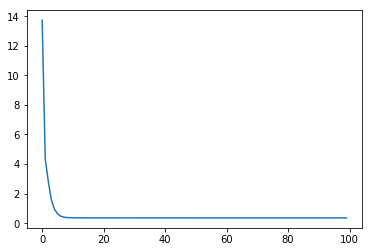

In [898]:
plt.plot(loss_hist);

In [899]:
outputs_test = model(x_test)
#loss = criterion(outputs_test, y_test)
#loss

In [938]:
agg_model = nn.Softmax(dim=1)

In [939]:
y_test_pred_sm = agg_model(outputs_test).argmax(1)

In [902]:
# Klassifikationsgenauigkeit
classification_accuracy_test =(y_test.float() == y_test_pred_sm.float()).float().mean()
classification_accuracy_test

tensor(0.8108)

# Forest classifier

In [400]:
RandomForestClassifier?

In [287]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [288]:
X_train, X_val, y_train, y_val = train_test_split(x.numpy(), y.numpy(), test_size = 0.25)

In [407]:
error_train = []
error_val = []
auc_val = []
auc_train = []

for i in range(1, 30):
    for j in range(1,50):
        for k in range(2,50):
            d_forest = RandomForestClassifier(
            n_estimators=i,
            criterion='gini',
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0,
            max_features='auto',
            max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_impurity_split=None,
            bootstrap=True,
            oob_score=False,
            n_jobs=-1,
            random_state=None,
            verbose=0,
            warm_start=False,
            class_weight=None,
            )
    d_forest.fit(X_train, y_train)
    y_pred_prob_train = d_forest.predict_proba(X_train)
    y_pred_prob_val = d_forest.predict_proba(X_val)
    error_train.append(metrics.mean_squared_error(y_train, y_pred_prob_train[:,1]))
    error_val.append(metrics.mean_squared_error(y_val, y_pred_prob_val[:,1]))

    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob_train[:,1])
    auc_train.append(metrics.auc(fpr, tpr))

    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred_prob_val[:,1])
    auc_val.append(metrics.auc(fpr, tpr))

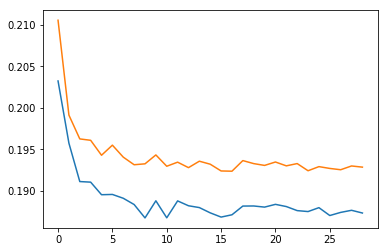

In [408]:
plt.plot(error_train)
plt.plot(error_val)

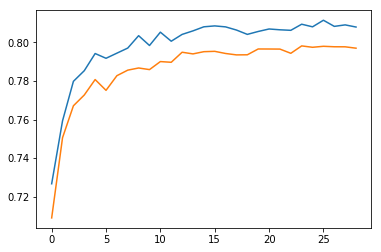

In [409]:
plt.plot(auc_train)
plt.plot(auc_val)

In [412]:
auc_val.index(max(auc_val))

23

In [410]:
error_val.index(min(error_val))

16

In [411]:
d_forest = RandomForestClassifier(n_estimators=24)

In [390]:
d_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=24, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [391]:
y_pred_test = d_forest.predict(x_test)
y_pred_prob_test = d_forest.predict_proba(x_test)

In [392]:
x_test.shape

torch.Size([25000, 348])

In [393]:
y_test.shape

torch.Size([25000])

In [394]:
y_pred_prob_test.shape

(25000, 2)

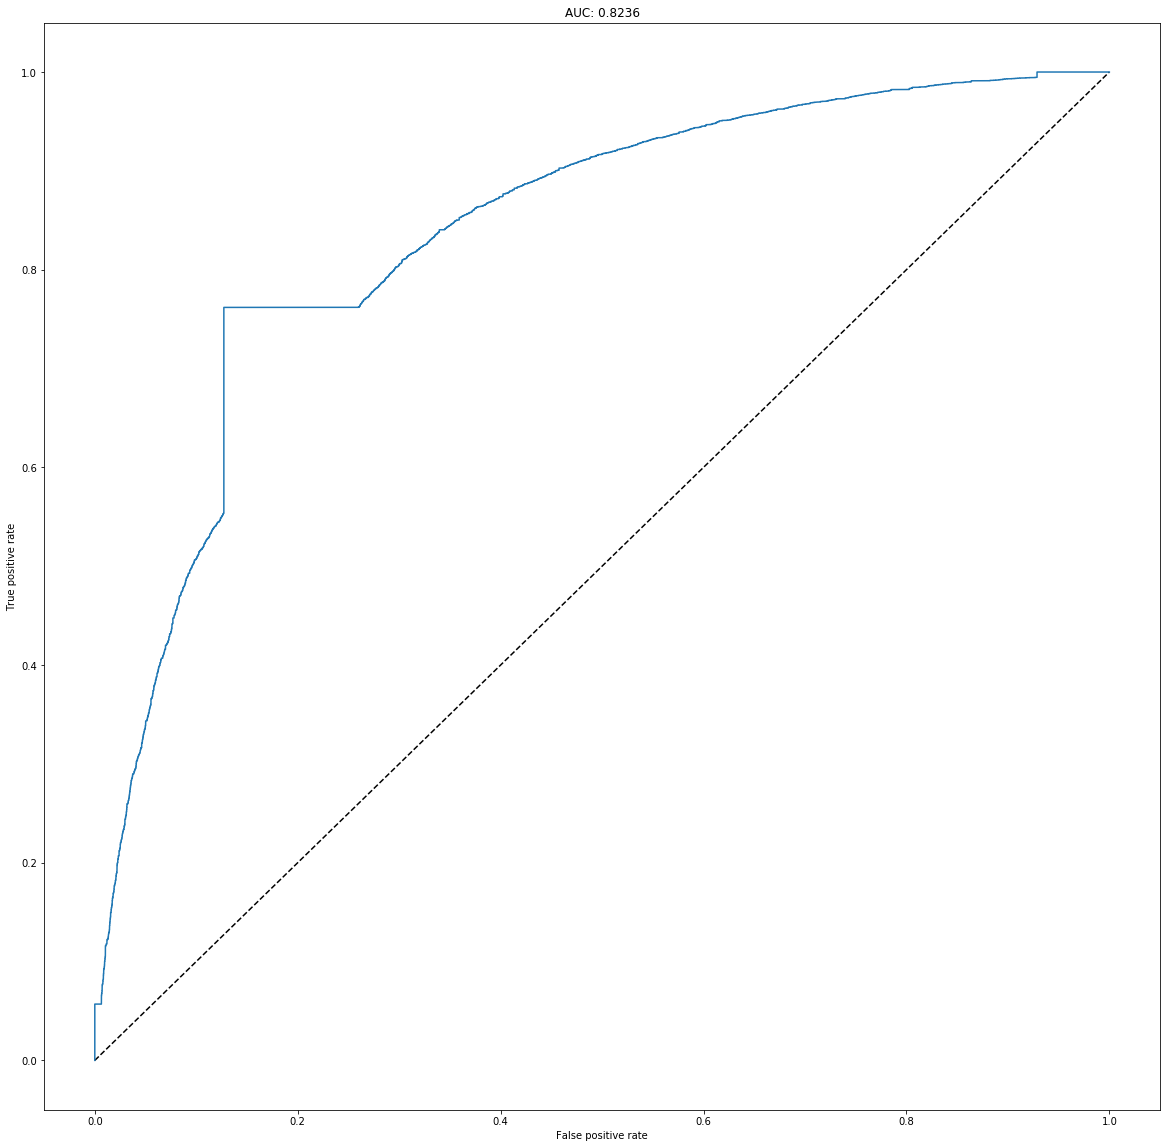

In [413]:
plt.figure(1, figsize=(20,20))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_test[:,1])
auc = metrics.auc(fpr, tpr)
plt.title('AUC: ' + str(round(auc,4)))
plt.step(fpr, tpr)

plt.show()

In [414]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_test[:,1])

In [415]:
pd_eval = pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':thresholds})

In [416]:
# Klassifikationsgenauigkeit
classification_accuracy_test = 1 * (y_test.numpy() == y_pred_test).mean()
classification_accuracy_test

0.7526

In [926]:
# Testdatensatz
missclassification_test = 1 * (y_test.numpy() != y_pred_test).mean()
missclassification_test

0.50076

# 

In [933]:
%%cython --a

cdef int a=5;
cdef int b=6;

b+=a

In [940]:
import re

In [1149]:
#re.findall("([\w][\w']*[\w])","Bromwell High is nothing short of brilliant. Expertly scripted and perfectly delivered, this searing parody of a students and teachers at a South London Public School leaves you literally rolling with laughter. It's vulgar, provocative, witty and sharp. The characters are a superbly caricatured cross section of British society (or to be more accurate, of any society). Following the escapades of Keisha, Latrina and Natella, our three ""protagonists"" for want of a better term, the show doesn't shy away from parodying every imaginable subject. Political correctness flies out the window in every episode. If you enjoy shows that aren't afraid to poke fun of every taboo subject imaginable, then Bromwell High will not disappoint!")

In [1147]:
#re.findall("([\w][\w']*[\w] +[\w][\w']*[\w])","Bromwell High is nothing short of brilliant. Expertly scripted and perfectly delivered, this searing parody of a students and teachers at a South London Public School leaves you literally rolling with laughter. It's vulgar, provocative, witty and sharp. The characters are a superbly caricatured cross section of British society (or to be more accurate, of any society). Following the escapades of Keisha, Latrina and Natella, our three ""protagonists"" for want of a better term, the show doesn't shy away from parodying every imaginable subject. Political correctness flies out the window in every episode. If you enjoy shows that aren't afraid to poke fun of every taboo subject imaginable, then Bromwell High will not disappoint!")

In [1148]:
#re.findall("([\w][\w']*[\w] +[\w][\w']*[\w] +[\w][\w']*[\w])",'Heute ist ein schöner Tag. Lass uns nach draußen gehen.')

In [1152]:
data_df = pd.read_json('/Users/cm/PycharmProjects/IMDB/data/IMDB/amazvideo/Amazon_Instant_Video_5.json', lines=True)

In [1153]:
data_df

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000H00VBQ,"[0, 0]",2,I had big expectations because I love English ...,"05 3, 2014",A11N155CW1UV02,AdrianaM,A little bit boring for me,1399075200
1,B000H00VBQ,"[0, 0]",5,I highly recommend this series. It is a must f...,"09 3, 2012",A3BC8O2KCL29V2,Carol T,Excellent Grown Up TV,1346630400
2,B000H00VBQ,"[0, 1]",1,This one is a real snoozer. Don't believe anyt...,"10 16, 2013",A60D5HQFOTSOM,"Daniel Cooper ""dancoopermedia""",Way too boring for me,1381881600
3,B000H00VBQ,"[0, 0]",4,Mysteries are interesting. The tension betwee...,"10 30, 2013",A1RJPIGRSNX4PW,"J. Kaplan ""JJ""",Robson Green is mesmerizing,1383091200
4,B000H00VBQ,"[1, 1]",5,"This show always is excellent, as far as briti...","02 11, 2009",A16XRPF40679KG,Michael Dobey,Robson green and great writing,1234310400
5,B000H00VBQ,"[12, 12]",5,I discovered this series quite by accident. Ha...,"10 11, 2011",A1POFVVXUZR3IQ,Z Hayes,I purchased the series via streaming and loved...,1318291200
6,B000H0X79O,"[0, 0]",3,"It beats watching a blank screen. However, I j...","10 15, 2013",A1PG2VV4W1WRPL,"Jimmy C. Saunders ""Papa Smurf""",It takes up your time.,1381795200
7,B000H0X79O,"[0, 0]",3,"There are many episodes in this series, so I p...","12 29, 2013",ATASGS8HZHGIB,JohnnyC,A reasonable way to kill a few minutes,1388275200
8,B000H0X79O,"[0, 0]",5,This is the best of the best comedy Stand-up. ...,"02 26, 2014",A3RXD7Z44T9DHW,Kansas,kansas001,1393372800
9,B000H0X79O,"[0, 0]",3,Not bad. Didn't know any of the comedians but...,"04 2, 2014",AUX8EUBNTHIIU,Louis V. Borsellino,Entertaining Comedy,1396396800


In [1044]:
data_test_amzv=np.zeros((data_df.shape[0], len(word_list)))

word1=''
for i in range(data_df.shape[0]):    
     for word in data_df['reviewText'][i].split(" "):
            word2=word
            if word1+' '+word2 in word_list:
                data_test_amzv[i][word_list[word1+' '+word2]]+=word_list[word1+' '+word2]
            word1=word2

In [1046]:
data_test_amzv.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [1047]:
pre.set('amznvideo',pd.DataFrame(data_test_amzv, columns=word_list))

In [1049]:
pre.get('amznvideo').describe()

,the best,a great,like a,movie was,could have,at least,the worst,is very,supposed to,as well,...,his life.,delivers a,any real,why did,the gore,performance and,tribute to,well done.,"/><br />Also,",which she
count,37126.0,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,...,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.000000,37126.0,37126.000000
mean,0.0,0.074638,0.061359,0.024969,0.075634,0.113532,0.038302,0.209664,0.087701,0.217449,...,1.272855,1.129263,1.391154,0.870280,1.219523,0.784706,0.959974,5.968997,0.0,0.933470
std,0.0,0.291203,0.378273,0.291466,0.654096,0.813960,0.491861,1.262011,0.939983,1.508758,...,41.692963,37.409655,38.665064,30.603251,37.926262,29.087883,33.146867,82.047511,0.0,34.636129
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,0.0,6.000000,8.000000,6.000000,28.000000,20.000000,12.000000,21.000000,32.000000,27.000000,...,4296.000000,2150.000000,1076.000000,1077.000000,2156.000000,1079.000000,2160.000000,2162.000000,0.0,2166.000000


In [1101]:
x_test_amz_video = torch.tensor(pre.data['amznvideo'].values).float()

In [1102]:
outputs_test_amz = model(x_test_amz_video)

In [1103]:
agg_model = nn.Softmax(dim=1)

In [1138]:
y_amzn=data_df['overall']//3

In [1139]:
y_test_pred_amz = agg_model(outputs_test_amz).argmax(1)

In [1140]:
y_test_pred_amz

tensor([0, 1, 1,  ..., 0, 1, 0])

In [1141]:
y_amzn_tens = torch.tensor(y_amzn)

In [1142]:
y_amzn_tens

tensor([0, 1, 0,  ..., 1, 1, 1])

In [1143]:
hans = (agg_model(outputs_test_amz)*5).long()

In [1144]:
hans[:,1]

tensor([2, 4, 2,  ..., 2, 2, 0])

In [1145]:
# Klassifikationsgenauigkeit
classification_accuracy_test =(y_amzn_tens == y_test_pred_amz).float().mean()
classification_accuracy_test

tensor(0.7956)

In [1146]:
(agg_model(outputs_test_amz)*5).int()

tensor([[2, 2],
        [0, 4],
        [2, 2],
        ...,
        [2, 2],
        [2, 2],
        [4, 0]], dtype=torch.int32)